Approach: 

- We have already preprocessed the data in our last step. Let's upload that data and also pre-process our test dataset.
- We will consider three sets in the model building :
       - Split the training data into : Train and Validate set
       - Check the score on Test set.
 

### Perform Sentiment Classification using supervised learning algorithms (Model Building)

In [1]:
#Import the packages
import nltk
import random
import pandas as pd
import numpy as np
import datetime
%matplotlib inline 
from contractions import CONTRACTION_MAP
import unicodedata
import re
import string
from nltk import FreqDist
from nltk.util import ngrams
from collections import Counter

import warnings
warnings.filterwarnings("ignore")

from nltk.classify.scikitlearn import SklearnClassifier
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix

from keras.preprocessing.text import Tokenizer          # for tokenizing text
from keras.preprocessing.sequence import pad_sequences  # for padding sentences with zeros. To make the sentence length same
from keras.utils import to_categorical                  # for one-hot encoding of the labels
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from keras.layers import SimpleRNN, LSTM, GRU, Input, Concatenate
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPool1D,GlobalMaxPool2D, Embedding, GlobalAvgPool1D
from keras.models import Sequential, Model
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

Using TensorFlow backend.


In [2]:
#Load the datasets

lionking_traindata=pd.read_csv("Lionking_Dataset_Cleaned.csv")
lionking_testdata=pd.read_csv("Lion_King_Review_Test.csv")

In [3]:
#Read the top few records.

lionking_traindata.head(3)

,ReviewID,Verified Reviewer,Platform,Review_Clean,sentiment
0,2c73ed20-5b9f-41b3-a4fd-8dd3ff8bb20a,True,Fandango,i liked most that the animation made the anima...,1
1,871398953,False,RT,amazing so realistic and incredible music,1
2,DD2453B0-37CE-4B47-A099-D15378FC310E,False,Fandango,classic good remake loved it glover was outsta...,1


We will only consider the Review and its sentiment for further analysis. So, lets drop the attributes which are not required.

In [4]:
#Drop the attributes which are not required for model building now.

lionking_traindata.drop(["ReviewID","Verified Reviewer","Platform"], axis = 1, inplace = True)

In [5]:
#Read the first few records of the dataset.

lionking_traindata.head(3)

,Review_Clean,sentiment
0,i liked most that the animation made the anima...,1
1,amazing so realistic and incredible music,1
2,classic good remake loved it glover was outsta...,1


As our traindata is already preprocessed, let's pre-process our test dataset with same steps.

### Preprocess the Test Dataset

In [6]:
#Read the first few records of the test dataset.

lionking_testdata.head(3)

,ReviewID,Review
0,92876,Was good. Nothing like the original but I beli...
1,92877,I absolutely loved it! A wonderful rendition o...
2,92878,I love the movie! Good job director! \nI appre...


In [7]:
#Applying Contractions

#We have one python file called "contractions.py" which has a function CONTRACTION_MAP.
#The function helps to expand the texts which are contraction format or written in shortcut trendy way to original text.
#This is required in the very first step so that we can have complete text reviews before proceeding with  further analysis on it.

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
            if contraction_mapping.get(match)\
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)

    return expanded_text

In [8]:
#Apply the defined function "expand_contractions" on the attribute "Review"
#Create a new column 'Review_Clean'  which will store the expanded text from review after the above function is applied.

lionking_testdata['Review_Clean']=[expand_contractions(re.sub('’',"'", each_review)) for each_review in lionking_testdata['Review']]

In [9]:
#Check the datatset now.

lionking_testdata.head(3)

,ReviewID,Review,Review_Clean
0,92876,Was good. Nothing like the original but I beli...,Was good. Nothing like the original but I beli...
1,92877,I absolutely loved it! A wonderful rendition o...,I absolutely loved it! A wonderful rendition o...
2,92878,I love the movie! Good job director! \nI appre...,I love the movie! Good job director! \nI appre...


In [10]:
#Convert the text into lower case.
cleanup_re = re.compile('[^a-z]+')
def cleanup_lower(review):
    review = review.lower()
    review = cleanup_re.sub(' ', review).strip()
    return review

In [11]:
#Apply the defined function "cleanup_lower" on the attribute "Review_Clean"

lionking_testdata['Review_Clean']=[cleanup_lower(each_review) for each_review in lionking_testdata['Review_Clean']]

In [12]:
#Read the first few records

lionking_testdata.head(3)

,ReviewID,Review,Review_Clean
0,92876,Was good. Nothing like the original but I beli...,was good nothing like the original but i belie...
1,92877,I absolutely loved it! A wonderful rendition o...,i absolutely loved it a wonderful rendition of...
2,92878,I love the movie! Good job director! \nI appre...,i love the movie good job director i appreciat...


In [13]:
#Removing the accented characters
def remove_accented_chars(text):
    text=unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8','ignore')
    return text

In [14]:
#Apply the defined function "remove_accented_chars" on the attribute "Review_Clean"

lionking_testdata['Review_Clean']=[remove_accented_chars(each_review) for each_review in lionking_testdata['Review_Clean']]

In [15]:
#Removing the scrub characters

def scrub_words(text):
    # Replace \xao characters in text -
    # \xa0 is actually non-breaking space in Latin1 (ISO 8859-1), also chr(160).
    text = re.sub('\xa0', ' ', text)

    # Replace non ascii and digits
    text = re.sub("(\\W|\\d)", ' ', text)

    # Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)

    # Remove html markup
    text = re.sub("<.*?>", ' ', text)

    return text

In [16]:
#Apply the defined function "scrub_words" on the attribute "Review_Clean"

lionking_testdata['Review_Clean']=[scrub_words(each_review) for each_review in lionking_testdata['Review_Clean']]

In [17]:
#Check the word count in each review and create a new attribute "Review_Word_Count"

lionking_testdata['Review_Word_Count']=[len(each_review.split(' ')) for each_review in lionking_testdata['Review_Clean']]

In [18]:
#Read the dataset now

lionking_testdata.head(3)

,ReviewID,Review,Review_Clean,Review_Word_Count
0,92876,Was good. Nothing like the original but I beli...,was good nothing like the original but i belie...,13
1,92877,I absolutely loved it! A wonderful rendition o...,i absolutely loved it a wonderful rendition of...,28
2,92878,I love the movie! Good job director! \nI appre...,i love the movie good job director i appreciat...,20


In [19]:
#Drop the attributes which are not required for model building now.

lionking_testdata.drop(["ReviewID","Review","Review_Word_Count"], axis = 1, inplace = True)

In [20]:
lionking_testdata.head(3)

,Review_Clean
0,was good nothing like the original but i belie...
1,i absolutely loved it a wonderful rendition of...
2,i love the movie good job director i appreciat...


###  Build Models using Train Data

In [21]:
#Check top few records of the training data.

lionking_traindata.head(3)

,Review_Clean,sentiment
0,i liked most that the animation made the anima...,1
1,amazing so realistic and incredible music,1
2,classic good remake loved it glover was outsta...,1


In [22]:
#Check the datatypes of the attributes.

lionking_traindata.dtypes

Review_Clean    object
sentiment        int64
dtype: object

In [23]:
#Convert the datatype of the target variable "sentiment" as categorical. 

lionking_traindata["sentiment"]=lionking_traindata["sentiment"].astype('category')

In [24]:
lionking_traindata.dtypes

Review_Clean      object
sentiment       category
dtype: object

In [25]:
#Check the count of the target variable.

lionking_traindata['sentiment'].value_counts()

1    2172
0     828
Name: sentiment, dtype: int64

In [26]:
#Here the sentiments are { 1: positive and 0 : Negative}
#But as we have to find the F1 score for negative sentiment, we need to change the sentiments as { 1:Negative and 0:Positive}

#So first lets change it as { 1: positive and 0 : Negative}

lionking_traindata['sentiment'] = lionking_traindata['sentiment'].map({1:"positive", 0: "negative"})

In [27]:
lionking_traindata['sentiment'].value_counts()

positive    2172
negative     828
Name: sentiment, dtype: int64

In [28]:
#Now change the values as { 1:Negative and 0:Positive}

lionking_traindata['sentiment'] = lionking_traindata['sentiment'].map({'positive': 0, 'negative': 1})

In [29]:

#Now check the value counts of the target variable.
lionking_traindata['sentiment'].value_counts()

0    2172
1     828
Name: sentiment, dtype: int64

In [30]:
lionking_traindata.head(3)

,Review_Clean,sentiment
0,i liked most that the animation made the anima...,0
1,amazing so realistic and incredible music,0
2,classic good remake loved it glover was outsta...,0


In [31]:
#check the dimensions of the entire dataset.

lionking_traindata.shape

(3000, 2)

In [32]:
#Target Variable 

target=lionking_traindata['sentiment']

In [33]:
#Predictors (Independent Attribute)

lionking_traindata=lionking_traindata['Review_Clean']

In [34]:
#Train and Validate Split

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(lionking_traindata, target, test_size=0.3, random_state=1234)

In [35]:
#Check the dimensions of each split

print("X_train Dimension is : ", X_train.shape)
print("X_val Dimension is : ", X_val.shape)
print("Y_train Dimension is : ", Y_train.shape)
print("Y_val Dimension is : ", Y_val.shape)

X_train Dimension is :  (2100,)
X_val Dimension is :  (900,)
Y_train Dimension is :  (2100,)
Y_val Dimension is :  (900,)


In [36]:
#Select the test data.

lionking_testdata=lionking_testdata['Review_Clean']

In [37]:
#Check the first few records
lionking_testdata.head(2)

0    was good nothing like the original but i belie...
1    i absolutely loved it a wonderful rendition of...
Name: Review_Clean, dtype: object

In [38]:
#Check the dimensions of the test data

print("Test Data Dimension is : ", lionking_testdata.shape)

Test Data Dimension is :  (1200,)


In [39]:
#Get doc-term matrix on train data

countvector=CountVectorizer(stop_words='english', lowercase=True, strip_accents='unicode', decode_error='ignore')
tdm_train=countvector.fit_transform(X_train)
mat_train=tdm_train.todense()
mat_train.shape

(2100, 3747)

In [40]:
mat_train

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [41]:
#Get doc-ter matrix for validate data

tdm_validate=countvector.transform(X_val)
mat_validate=tdm_validate.todense()
mat_validate.shape

(900, 3747)

In [42]:
mat_validate

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [43]:
#Get doc-term matrix for test data

tdm_test=countvector.transform(lionking_testdata)
mat_test=tdm_test.todense()
mat_test.shape

(1200, 3747)

In [44]:
mat_test

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [45]:
#Logistic Regression

from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings("ignore") #just to ignore any warnings


#Training the model

logreg=LogisticRegression()
logreg_model1=logreg.fit(tdm_train, Y_train)

#Predicting the train data
train_pred= logreg_model1.predict(tdm_train)

#Predicting the validate data
valid_pred=logreg_model1.predict(tdm_validate)

#Predicting the test data
test_pred= logreg_model1.predict(tdm_test)

In [46]:
print("Train Confusion Matrix: \n", confusion_matrix(Y_train,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(Y_val,valid_pred))

Train Confusion Matrix: 
 [[1483   24]
 [  89  504]]
Validate Confusion Matrix: 
 [[607  58]
 [ 96 139]]


In [47]:
#Accuracy Precision Recall and F1 score on logistic model for Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(Y_train, train_pred))
print("The precision score for train:",precision_score(Y_train, train_pred))
print("The recall score for train:",recall_score(Y_train, train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(Y_train, train_pred))

The accuracy score for train: 0.9461904761904761
The precision score for train: 0.9545454545454546
The recall score for train: 0.8499156829679595
The F1 Score for negative reviews on Train: 0.8991971454058876


In [48]:
#Accuracy Precision Recall and F1 score on logistic model for Validation Data

print("The accuracy score for validate:",accuracy_score(Y_val,valid_pred))
print("The precision score for validate:",precision_score(Y_val,valid_pred))
print("The recall score for validate:",recall_score(Y_val,valid_pred))
print("The F1 Score for negative reviews on validate:", f1_score(Y_val,valid_pred))

The accuracy score for validate: 0.8288888888888889
The precision score for validate: 0.7055837563451777
The recall score for validate: 0.5914893617021276
The F1 Score for negative reviews on validate: 0.6435185185185184


In [49]:
#Build Naiive Bayes Model : Multinomial Naiive Bayes

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
naivebayes_model= classifier.fit(tdm_train, Y_train)

#Predicting the train data
train_pred= naivebayes_model.predict(tdm_train)

#Predicting the validate data
valid_pred=naivebayes_model.predict(tdm_validate)
 
#Predicting the test data
test_pred= naivebayes_model.predict(tdm_test)

In [50]:
print("Train Confusion Matrix: \n", confusion_matrix(Y_train,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(Y_val,valid_pred))

Train Confusion Matrix: 
 [[1461   46]
 [ 134  459]]
Validate Confusion Matrix: 
 [[604  61]
 [ 84 151]]


In [51]:
#Accuracy Precision Recall and F1 score on Multinomial Naiive Bayes model for Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(Y_train, train_pred))
print("The precision score for train:",precision_score(Y_train, train_pred))
print("The recall score for train:",recall_score(Y_train, train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(Y_train, train_pred))

The accuracy score for train: 0.9142857142857143
The precision score for train: 0.9089108910891089
The recall score for train: 0.7740303541315345
The F1 Score for negative reviews on Train: 0.8360655737704918


In [52]:
#Accuracy Precision Recall and F1 score on Multinomial Naiive Bayes model for Validation Data

print("The accuracy score for validate:",accuracy_score(Y_val,valid_pred))
print("The precision score for validate:",precision_score(Y_val,valid_pred))
print("The recall score for validate:",recall_score(Y_val,valid_pred))
print("The F1 Score for negative reviews on validate:", f1_score(Y_val,valid_pred))

The accuracy score for validate: 0.8388888888888889
The precision score for validate: 0.7122641509433962
The recall score for validate: 0.6425531914893617
The F1 Score for negative reviews on validate: 0.6756152125279643


In [53]:
#We need to analyse the test predictions by uploading the file 

test_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

In [54]:
test_pred.shape

(1200,)

In [55]:
#Submission Format

test_submission1=pd.read_csv("Submission_Format.csv")

In [56]:
test_submission1.head(2)

,ReviewID
0,92876
1,92877


In [57]:
#Add the column "test_pred" into the submission file

test_submission1['sentiment']=test_pred

In [58]:
test_submission1.head(3)

,ReviewID,sentiment
0,92876,0
1,92877,0
2,92878,0


In [59]:
#Save the file on the system.

test_submission1.to_csv("2794_Submission1.csv",index=False)

The test submission F1 score is : 0.67

### Build Another Model

#### Lets load the datasets again and start pre-processing models from starting.



In [60]:
reviews_train=pd.read_csv("Lion_King_Review.csv")
reviews_test=pd.read_csv("Lion_King_Review_Test.csv")

In [61]:
reviews_train.head(3)

,Unnamed: 0,createDate,displayImageUrl,displayName,hasProfanity,hasSpoilers,isSuperReviewer,isVerified,rating,review,score,timeFromCreation,updateDate,userAccountLink,userDisplayName,userId,userRealm
0,0,2019-08-18T08:54:30.664Z,NaN,Joanne H,False,False,False,True,STAR_5,I liked most that the animation made the anima...,5.0,31m ago,2019-08-18T08:54:30.890Z,NaN,Joanne H,2c73ed20-5b9f-41b3-a4fd-8dd3ff8bb20a,Fandango
1,1,2019-08-18T08:03:49.380Z,https://graph.facebook.com/v3.3/594379764/picture,Frankie C,False,False,False,False,STAR_5,Amazing! So realistic and incredible music,5.0,1h ago,2019-08-18T08:03:49.380Z,/user/id/871398953,Frankie C,871398953,RT
2,2,2019-08-18T07:13:32.422Z,NaN,jaycee,False,False,False,False,STAR_5,Classic. Good remake. Loved it. Glover was out...,5.0,2h ago,2019-08-18T07:13:32.422Z,NaN,jaycee,DD2453B0-37CE-4B47-A099-D15378FC310E,Fandango


In [62]:
reviews_test.head(3)

,ReviewID,Review
0,92876,Was good. Nothing like the original but I beli...
1,92877,I absolutely loved it! A wonderful rendition o...
2,92878,I love the movie! Good job director! \nI appre...


In [63]:
#Select the columns which is required for model building in the train-set.

reviews_train=reviews_train[['review','score']]

In [64]:
reviews_train.head(3)

,review,score
0,I liked most that the animation made the anima...,5.0
1,Amazing! So realistic and incredible music,5.0
2,Classic. Good remake. Loved it. Glover was out...,5.0


In [65]:
#Create a new variable "sentiment" as target variable.

#The condition is : Rating >3 then postive | Rating <3 then negative.

reviews_train["sentiment"] = reviews_train["score"].apply(lambda score: "positive" if score > 3.0 else "negative")

In [66]:
reviews_train.head(3)

,review,score,sentiment
0,I liked most that the animation made the anima...,5.0,positive
1,Amazing! So realistic and incredible music,5.0,positive
2,Classic. Good remake. Loved it. Glover was out...,5.0,positive


In [67]:
#Now change the values as { 1:Negative and 0:Positive}

reviews_train['sentiment'] = reviews_train['sentiment'].map({'positive': 0, 'negative': 1})

In [68]:
reviews_train.drop('score', axis = 1, inplace = True)

In [69]:
reviews_train.head(3)

,review,sentiment
0,I liked most that the animation made the anima...,0
1,Amazing! So realistic and incredible music,0
2,Classic. Good remake. Loved it. Glover was out...,0


In [70]:
import re

REPLACE_NO_SPACE = re.compile("[.;:!\'?,\"()\[\]]")
REPLACE_WITH_SPACE = re.compile("(<br\s*/><br\s*/>)|(\-)|(\/)")

def preprocess_reviews(reviews):
    reviews = [REPLACE_NO_SPACE.sub("", line.lower()) for line in reviews]
    reviews = [REPLACE_WITH_SPACE.sub(" ", line) for line in reviews]
    
    return reviews

reviews_train['review_clean'] = preprocess_reviews(reviews_train['review'])
reviews_test['review_clean'] = preprocess_reviews(reviews_test['Review'])

In [71]:
reviews_train.head(3)

,review,sentiment,review_clean
0,I liked most that the animation made the anima...,0,i liked most that the animation made the anima...
1,Amazing! So realistic and incredible music,0,amazing so realistic and incredible music
2,Classic. Good remake. Loved it. Glover was out...,0,classic good remake loved it glover was outsta...


In [72]:
#Vectorize the cleaned data

from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(binary=True)
cv.fit(reviews_train['review_clean'])
train_cv = cv.transform(reviews_train['review_clean'])
test_cv= cv.transform(reviews_test['review_clean'])

In [73]:
target=reviews_train['sentiment']

In [74]:
target.head(3)

0    0
1    0
2    0
Name: sentiment, dtype: int64

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


#Train and Validate Split
X_train, X_val, Y_train, Y_val = train_test_split(train_cv, target, test_size=0.3, random_state=1234)

In [76]:
#Check the dimensions of each split

print("X_train Dimension is : ", X_train.shape)
print("X_test Dimension is : ", X_val.shape)
print("Y_train Dimension is : ", Y_train.shape)
print("Y_test Dimension is : ", Y_val.shape)

X_train Dimension is :  (2100, 4897)
X_test Dimension is :  (900, 4897)
Y_train Dimension is :  (2100,)
Y_test Dimension is :  (900,)


In [77]:
#Check the dimensions of the test data

print("Test Data Dimension is : ", test_cv.shape)


Test Data Dimension is :  (1200, 4897)


In [78]:
#Logistic Regression Model

#Training the model
logreg2 = LogisticRegression()
logreg_model2=logreg2.fit(X_train,Y_train)

#Predicting the train data
train_pred= logreg_model2.predict(X_train)

#Predicting the validate data
valid_pred=logreg_model2.predict(X_val)

#Predicting the test data
test_pred= logreg_model2.predict(test_cv)

In [79]:
print("Train Confusion Matrix: \n", confusion_matrix(Y_train,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(Y_val,valid_pred))

Train Confusion Matrix: 
 [[1490   17]
 [  48  545]]
Validate Confusion Matrix: 
 [[610  55]
 [ 86 149]]


In [80]:
#Accuracy Precision Recall and F1 score on logistic model for Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(Y_train, train_pred))
print("The precision score for train:",precision_score(Y_train, train_pred))
print("The recall score for train:",recall_score(Y_train, train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(Y_train, train_pred))

The accuracy score for train: 0.969047619047619
The precision score for train: 0.9697508896797153
The recall score for train: 0.9190556492411467
The F1 Score for negative reviews on Train: 0.9437229437229437


In [81]:
#Accuracy Precision Recall and F1 score on logistic model for Validation Data

print("The accuracy score for validate:",accuracy_score(Y_val,valid_pred))
print("The precision score for validate:",precision_score(Y_val,valid_pred))
print("The recall score for validate:",recall_score(Y_val,valid_pred))
print("The F1 Score for negative reviews on validate:", f1_score(Y_val,valid_pred))

The accuracy score for validate: 0.8433333333333334
The precision score for validate: 0.7303921568627451
The recall score for validate: 0.6340425531914894
The F1 Score for negative reviews on validate: 0.6788154897494305


In [82]:
#We need to analyse the test predictions by uploading the file 

test_pred

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [83]:
test_pred.shape

(1200,)

In [84]:
#Submission Format

test_submission2=pd.read_csv("Submission_Format.csv")

In [85]:
test_submission2.head(2)

,ReviewID
0,92876
1,92877


In [86]:
#Add the column "test_pred" into the submission file

test_submission2['sentiment']=test_pred

In [87]:
test_submission2.head(3)

,ReviewID,sentiment
0,92876,0
1,92877,0
2,92878,0


In [88]:
#Save the file on the system.

test_submission2.to_csv("2794_Submission2.csv",index=False)

The test submission2 F1 score is : 0.69

In [89]:
#Build Naiive Bayes Model: Multinomial Naiive Bayes

from sklearn.naive_bayes import MultinomialNB
classifier = MultinomialNB()
naivebayes_model= classifier.fit(X_train, Y_train)

#Predicting the train data
train_pred= naivebayes_model.predict(X_train)

#Predicting the validate data
valid_pred=naivebayes_model.predict(X_val)

#Predicting the test data
test_pred= naivebayes_model.predict(test_cv)

In [90]:
print("Train Confusion Matrix: \n", confusion_matrix(Y_train,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(Y_val,valid_pred))

Train Confusion Matrix: 
 [[1478   29]
 [ 148  445]]
Validate Confusion Matrix: 
 [[613  52]
 [ 93 142]]


In [91]:
#Accuracy Precision Recall and F1 score on Multinomial Naiive Bayes Model for Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(Y_train, train_pred))
print("The precision score for train:",precision_score(Y_train, train_pred))
print("The recall score for train:",recall_score(Y_train, train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(Y_train, train_pred))

The accuracy score for train: 0.9157142857142857
The precision score for train: 0.9388185654008439
The recall score for train: 0.7504215851602024
The F1 Score for negative reviews on Train: 0.8341143392689785


In [92]:
#Accuracy Precision Recall and F1 score on Multinomial Naiive Bayes model for Validation Data

print("The accuracy score for validate:",accuracy_score(Y_val,valid_pred))
print("The precision score for validate:",precision_score(Y_val,valid_pred))
print("The recall score for validate:",recall_score(Y_val,valid_pred))
print("The F1 Score for negative reviews on validate:", f1_score(Y_val,valid_pred))

The accuracy score for validate: 0.8388888888888889
The precision score for validate: 0.7319587628865979
The recall score for validate: 0.6042553191489362
The F1 Score for negative reviews on validate: 0.6620046620046621


In [93]:
#Lets clean our datasets more

#Read the train and test dataset.
reviews_train.head(3)

,review,sentiment,review_clean
0,I liked most that the animation made the anima...,0,i liked most that the animation made the anima...
1,Amazing! So realistic and incredible music,0,amazing so realistic and incredible music
2,Classic. Good remake. Loved it. Glover was out...,0,classic good remake loved it glover was outsta...


In [94]:
reviews_test.head(3)

,ReviewID,Review,review_clean
0,92876,Was good. Nothing like the original but I beli...,was good nothing like the original but i belie...
1,92877,I absolutely loved it! A wonderful rendition o...,i absolutely loved it a wonderful rendition of...
2,92878,I love the movie! Good job director! \nI appre...,i love the movie good job director \ni appreci...


In [95]:
#Removing Stop words
from nltk.corpus import stopwords

english_stop_words = stopwords.words('english')
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split() 
                      if word not in english_stop_words])
        )
    return removed_stop_words


reviews_train['review_clean']=remove_stop_words(reviews_train['review_clean'])
reviews_test['review_clean']=remove_stop_words(reviews_test['review_clean'])

In [96]:
#Lemmatization

def get_lemmatized_text(corpus):
    from nltk.stem import WordNetLemmatizer
    lemmatizer = WordNetLemmatizer()
    return [' '.join([lemmatizer.lemmatize(word) for word in review.split()]) for review in corpus]

reviews_train['review_clean']=get_lemmatized_text(reviews_train['review_clean'])
reviews_test['review_clean']=get_lemmatized_text(reviews_test['review_clean'])

In [97]:
#N-Grams

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1,2))
ngram_vectorizer.fit(reviews_train['review_clean'])
train_ngram = ngram_vectorizer.transform(reviews_train['review_clean'])
test_ngram = ngram_vectorizer.transform(reviews_test['review_clean'])


In [98]:
target=reviews_train['sentiment']

In [99]:
target.head(3)

0    0
1    0
2    0
Name: sentiment, dtype: int64

In [100]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


#Train and Validate Split
X_train, X_val, Y_train, Y_val = train_test_split(train_ngram, target, test_size=0.3, random_state=1234)

In [101]:
#Check the dimensions of each split

print("X_train Dimension is : ", X_train.shape)
print("X_val Dimension is : ", X_val.shape)
print("Y_train Dimension is : ", Y_train.shape)
print("Y_val Dimension is : ", Y_val.shape)

X_train Dimension is :  (2100, 30947)
X_val Dimension is :  (900, 30947)
Y_train Dimension is :  (2100,)
Y_val Dimension is :  (900,)


In [102]:
test_ngram.shape

(1200, 30947)

In [103]:
#Logistic Regression Model

#Training the model
logreg3 = LogisticRegression()
logreg_model3=logreg3.fit(X_train,Y_train)

#Predicting the train data
train_pred= logreg_model3.predict(X_train)

#Predicting the validate data
valid_pred=logreg_model3.predict(X_val)

#Predicting the test dataa
test_pred= logreg_model3.predict(test_ngram)

In [104]:
print("Train Confusion Matrix: \n", confusion_matrix(Y_train,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(Y_val,valid_pred))

Train Confusion Matrix: 
 [[1506    1]
 [  12  581]]
Validate Confusion Matrix: 
 [[618  47]
 [106 129]]


In [105]:
#Accuracy Precision Recall and F1 score on logistic model for Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(Y_train, train_pred))
print("The precision score for train:",precision_score(Y_train, train_pred))
print("The recall score for train:",recall_score(Y_train, train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(Y_train, train_pred))

The accuracy score for train: 0.9938095238095238
The precision score for train: 0.9982817869415808
The recall score for train: 0.9797639123102867
The F1 Score for negative reviews on Train: 0.988936170212766


In [106]:
#Accuracy Precision Recall and F1 score on logistic model for Validation Data

print("The accuracy score for validate:",accuracy_score(Y_val,valid_pred))
print("The precision score for validate:",precision_score(Y_val,valid_pred))
print("The recall score for validate:",recall_score(Y_val,valid_pred))
print("The F1 Score for negative reviews on validate:", f1_score(Y_val,valid_pred))

The accuracy score for validate: 0.83
The precision score for validate: 0.7329545454545454
The recall score for validate: 0.548936170212766
The F1 Score for negative reviews on validate: 0.6277372262773723


In [107]:
#Support Vector Model

from sklearn.svm import LinearSVC

#Training the model
svc = LinearSVC()
svc_model1=svc.fit(X_train,Y_train)

#Predicting the train data
train_pred= svc_model1.predict(X_train)

#Predicting the validate data
valid_pred=svc_model1.predict(X_val)

#Predicting the test data
test_pred= svc_model1.predict(test_ngram)

In [108]:
print("Train Confusion Matrix: \n", confusion_matrix(Y_train,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(Y_val,valid_pred))

Train Confusion Matrix: 
 [[1507    0]
 [   0  593]]
Validate Confusion Matrix: 
 [[608  57]
 [ 90 145]]


In [109]:
#Accuracy Precision Recall and F1 score on logistic model for Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(Y_train, train_pred))
print("The precision score for train:",precision_score(Y_train, train_pred))
print("The recall score for train:",recall_score(Y_train, train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(Y_train, train_pred))

The accuracy score for train: 1.0
The precision score for train: 1.0
The recall score for train: 1.0
The F1 Score for negative reviews on Train: 1.0


In [110]:
#Accuracy Precision Recall and F1 score on logistic model for Validation Data

print("The accuracy score for validate:",accuracy_score(Y_val,valid_pred))
print("The precision score for validate:",precision_score(Y_val,valid_pred))
print("The recall score for validate:",recall_score(Y_val,valid_pred))
print("The F1 Score for negative reviews on validate:", f1_score(Y_val,valid_pred))

The accuracy score for validate: 0.8366666666666667
The precision score for validate: 0.7178217821782178
The recall score for validate: 0.6170212765957447
The F1 Score for negative reviews on validate: 0.6636155606407322


In [111]:
#Neural Network Model
model = Sequential()

model.add(Dense(6, input_dim=30947, activation='relu', kernel_initializer='normal'))
model.add(Dense(8, activation='relu', kernel_initializer='normal'))
model.add(Dense(7, activation='relu', kernel_initializer='normal'))
model.add(Dense(1, activation='sigmoid', kernel_initializer='normal'))

In [112]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [113]:
model.fit(X_train, Y_train, epochs=10,batch_size=40)

Epoch 1/10
2100/2100 [==============================] - 2s 812us/step - loss: 0.6866 - acc: 0.7110
Epoch 2/10
2100/2100 [==============================] - 1s 633us/step - loss: 0.6559 - acc: 0.7176
Epoch 3/10
2100/2100 [==============================] - 1s 635us/step - loss: 0.5207 - acc: 0.7176
Epoch 4/10
2100/2100 [==============================] - 1s 635us/step - loss: 0.3546 - acc: 0.7719
Epoch 5/10
2100/2100 [==============================] - 1s 632us/step - loss: 0.2359 - acc: 0.9386
Epoch 6/10
2100/2100 [==============================] - 1s 637us/step - loss: 0.1514 - acc: 0.9724
Epoch 7/10
2100/2100 [==============================] - 1s 650us/step - loss: 0.0928 - acc: 0.9862
Epoch 8/10
2100/2100 [==============================] - 1s 657us/step - loss: 0.0584 - acc: 0.9933
Epoch 9/10
2100/2100 [==============================] - 1s 691us/step - loss: 0.0388 - acc: 0.9957
Epoch 10/10
2100/2100 [==============================] - 1s 681us/step - loss: 0.0276 - acc: 0.9971


In [114]:
#Predict the classes

train_pred=model.predict_classes(X_train)
val_pred=model.predict_classes(X_val)
test_pred=model.predict_classes(test_ngram)

In [115]:
#Confusion Matrix

print("Train Confusion Matrix: \n", confusion_matrix(Y_train,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(Y_val,valid_pred))

Train Confusion Matrix: 
 [[1506    1]
 [   4  589]]
Validate Confusion Matrix: 
 [[608  57]
 [ 90 145]]


In [116]:
#Accuracy Precision Recall and F1 score on deep network model for Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(Y_train, train_pred))
print("The precision score for train:",precision_score(Y_train, train_pred))
print("The recall score for train:",recall_score(Y_train, train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(Y_train, train_pred))

The accuracy score for train: 0.9976190476190476
The precision score for train: 0.9983050847457627
The recall score for train: 0.9932546374367622
The F1 Score for negative reviews on Train: 0.9957734573119189


In [117]:
#Accuracy Precision Recall and F1 score on deep network model for Validation Data

print("The accuracy score for validate:",accuracy_score(Y_val,valid_pred))
print("The precision score for validate:",precision_score(Y_val,valid_pred))
print("The recall score for validate:",recall_score(Y_val,valid_pred))
print("The F1 Score for negative reviews on validate:", f1_score(Y_val,valid_pred))

The accuracy score for validate: 0.8366666666666667
The precision score for validate: 0.7178217821782178
The recall score for validate: 0.6170212765957447
The F1 Score for negative reviews on validate: 0.6636155606407322


In [118]:
#We need to analyse the test predictions by uploading the file 

test_pred

array([[1],
       [0],
       [0],
       ...,
       [1],
       [0],
       [0]])

In [119]:
test_pred.shape

(1200, 1)

In [120]:
#Submission Format

test_submission3=pd.read_csv("Submission_Format.csv")

In [121]:
test_submission3.head(3)

,ReviewID
0,92876
1,92877
2,92878


In [122]:
#Add the column "test_pred" into the submission file

test_submission3['sentiment']=test_pred

In [123]:
test_submission3.head(3)

,ReviewID,sentiment
0,92876,1
1,92877,0
2,92878,0


In [124]:
#Save the file on the system.

test_submission3.to_csv("2794_Submission3.csv",index=False)

F1 score Submission 3 is: 0.56

In [125]:
## Lets try giving our own stop words

stop_words = ['in', 'of', 'at', 'a', 'the']

#N-Grams

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1,3), stop_words=stop_words)
ngram_vectorizer.fit(reviews_train['review_clean'])
train_ngram = ngram_vectorizer.transform(reviews_train['review_clean'])
test_ngram = ngram_vectorizer.transform(reviews_test['review_clean'])

In [126]:
target=reviews_train['sentiment']

In [127]:
target.head(3)

0    0
1    0
2    0
Name: sentiment, dtype: int64

In [128]:

from sklearn.model_selection import train_test_split


#Train and Validate Split
X_train, X_val, Y_train, Y_val = train_test_split(train_ngram, target, test_size=0.3, random_state=1234)

In [129]:
#Check the dimensions of each split

print("X_train Dimension is : ", X_train.shape)
print("X_val Dimension is : ", X_val.shape)
print("Y_train Dimension is : ", Y_train.shape)
print("Y_val Dimension is : ", Y_val.shape)

X_train Dimension is :  (2100, 64434)
X_val Dimension is :  (900, 64434)
Y_train Dimension is :  (2100,)
Y_val Dimension is :  (900,)


In [130]:
#Support Vector Model

from sklearn.svm import LinearSVC

#Training the model
svc = LinearSVC()
svc_model1=svc.fit(X_train,Y_train)

#Predicting the train data
train_pred= svc_model1.predict(X_train)

#Predicting the validate data
valid_pred=svc_model1.predict(X_val)

#Predicting the test data
test_pred= svc_model1.predict(test_ngram)

In [131]:
print("Train Confusion Matrix: \n", confusion_matrix(Y_train,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(Y_val,valid_pred))

Train Confusion Matrix: 
 [[1507    0]
 [   0  593]]
Validate Confusion Matrix: 
 [[611  54]
 [ 99 136]]


In [132]:
#Accuracy Precision Recall and F1 score on logistic model for Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(Y_train, train_pred))
print("The precision score for train:",precision_score(Y_train, train_pred))
print("The recall score for train:",recall_score(Y_train, train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(Y_train, train_pred))

The accuracy score for train: 1.0
The precision score for train: 1.0
The recall score for train: 1.0
The F1 Score for negative reviews on Train: 1.0


In [133]:
#Accuracy Precision Recall and F1 score on logistic model for Validation Data

print("The accuracy score for validate:",accuracy_score(Y_val,valid_pred))
print("The precision score for validate:",precision_score(Y_val,valid_pred))
print("The recall score for validate:",recall_score(Y_val,valid_pred))
print("The F1 Score for negative reviews on validate:", f1_score(Y_val,valid_pred))

The accuracy score for validate: 0.83
The precision score for validate: 0.7157894736842105
The recall score for validate: 0.5787234042553191
The F1 Score for negative reviews on validate: 0.6399999999999999


In [134]:
#Logistic Regression Model

#Training the model
logreg4 = LogisticRegression()
logreg_model4=logreg4.fit(X_train,Y_train)

#Predicting the train data
train_pred= logreg_model4.predict(X_train)

#Predicting the validate data
valid_pred=logreg_model4.predict(X_val)

#Predicting the test data
test_pred= logreg_model4.predict(test_ngram)

In [135]:
print("Train Confusion Matrix: \n", confusion_matrix(Y_train,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(Y_val,valid_pred))

Train Confusion Matrix: 
 [[1507    0]
 [   9  584]]
Validate Confusion Matrix: 
 [[622  43]
 [110 125]]


In [136]:
#Accuracy Precision Recall and F1 score on logistic model for Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(Y_train, train_pred))
print("The precision score for train:",precision_score(Y_train, train_pred))
print("The recall score for train:",recall_score(Y_train, train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(Y_train, train_pred))

The accuracy score for train: 0.9957142857142857
The precision score for train: 1.0
The recall score for train: 0.984822934232715
The F1 Score for negative reviews on Train: 0.9923534409515719


In [137]:
#Accuracy Precision Recall and F1 score on logistic model for Validation Data

print("The accuracy score for validate:",accuracy_score(Y_val,valid_pred))
print("The precision score for validate:",precision_score(Y_val,valid_pred))
print("The recall score for validate:",recall_score(Y_val,valid_pred))
print("The F1 Score for negative reviews on validate:", f1_score(Y_val,valid_pred))

The accuracy score for validate: 0.83
The precision score for validate: 0.7440476190476191
The recall score for validate: 0.5319148936170213
The F1 Score for negative reviews on validate: 0.6203473945409429


### Model Building using Neural Networks 

In [138]:
#Lets load the dataset again and pre-process it.

In [139]:
#Load the datasets

train_data=pd.read_csv("Lion_King_Review.csv")
test_data=pd.read_csv("Lion_King_Review_Test.csv")

In [140]:
#Read the first few records of train dataset

train_data.head(3)

,Unnamed: 0,createDate,displayImageUrl,displayName,hasProfanity,hasSpoilers,isSuperReviewer,isVerified,rating,review,score,timeFromCreation,updateDate,userAccountLink,userDisplayName,userId,userRealm
0,0,2019-08-18T08:54:30.664Z,NaN,Joanne H,False,False,False,True,STAR_5,I liked most that the animation made the anima...,5.0,31m ago,2019-08-18T08:54:30.890Z,NaN,Joanne H,2c73ed20-5b9f-41b3-a4fd-8dd3ff8bb20a,Fandango
1,1,2019-08-18T08:03:49.380Z,https://graph.facebook.com/v3.3/594379764/picture,Frankie C,False,False,False,False,STAR_5,Amazing! So realistic and incredible music,5.0,1h ago,2019-08-18T08:03:49.380Z,/user/id/871398953,Frankie C,871398953,RT
2,2,2019-08-18T07:13:32.422Z,NaN,jaycee,False,False,False,False,STAR_5,Classic. Good remake. Loved it. Glover was out...,5.0,2h ago,2019-08-18T07:13:32.422Z,NaN,jaycee,DD2453B0-37CE-4B47-A099-D15378FC310E,Fandango


In [141]:
#Read the first few records of test dataset
test_data.head(3)

,ReviewID,Review
0,92876,Was good. Nothing like the original but I beli...
1,92877,I absolutely loved it! A wonderful rendition o...
2,92878,I love the movie! Good job director! \nI appre...


In [142]:
#Select only those attributes which are required.

train_data=train_data[['review','score']]

In [143]:
#Read the first few records

train_data.head(3)

,review,score
0,I liked most that the animation made the anima...,5.0
1,Amazing! So realistic and incredible music,5.0
2,Classic. Good remake. Loved it. Glover was out...,5.0


In [144]:
#Create a new variable "sentiment" as target variable.

#The condition is : Rating >3 then postive | Rating <3 then negative.

train_data["sentiment"] = train_data["score"].apply(lambda score: "positive" if score > 3.0 else "negative")

In [145]:
#Drop the attribute which is not required.

train_data.drop('score', axis = 1, inplace = True)

In [146]:
#Now change the values as { 1:Negative and 0:Positive}

train_data['sentiment'] = train_data['sentiment'].map({'positive': 0, 'negative': 1})

In [147]:
train_data.head(3)

,review,sentiment
0,I liked most that the animation made the anima...,0
1,Amazing! So realistic and incredible music,0
2,Classic. Good remake. Loved it. Glover was out...,0


In [148]:
test_data.head(3)

,ReviewID,Review
0,92876,Was good. Nothing like the original but I beli...
1,92877,I absolutely loved it! A wonderful rendition o...
2,92878,I love the movie! Good job director! \nI appre...


### Lets Build CNN-1D Model.


In [149]:
#Split the training data into train and validation sets in the ratio 70:30

valid_data=train_data.iloc[2100:,]

In [150]:
valid_data.shape

(900, 2)

In [151]:
train_data=train_data.iloc[0:2100,]

In [152]:
## Define the sequence lengths, max number of words and embedding dimensions
MAX_SEQUENCE_LENGTH = 300   # Sequence length of each sentence. If more, crop. If less, pad with zeros
MAX_NB_WORDS = 20000        # Top 20000 frequently occuring words

In [153]:
#Target Attribute "sentiment"

train_target=train_data[['sentiment']]
valid_target=valid_data[['sentiment']]

In [154]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)   # get the frequently occuring words
tokenizer.fit_on_texts(train_data['review'])           
train_sequences =tokenizer.texts_to_sequences(train_data['review'])
valid_sequences =tokenizer.texts_to_sequences(valid_data['review'])
test_sequences = tokenizer.texts_to_sequences(test_data['Review'])

word_index = tokenizer.word_index               # dictionary containing words and their index
print('Found %s unique tokens.' % len(word_index)) # total words in the corpus
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH) # get only the top frequent words on train
valid_data = pad_sequences(valid_sequences, maxlen=MAX_SEQUENCE_LENGTH) # get only the top frequent words on validation
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)   # get only the top frequent words on test

print(train_data.shape)
print(test_data.shape)
print(valid_data.shape)

Found 4110 unique tokens.
(2100, 300)
(1200, 300)
(900, 300)


In [155]:
print(word_index)

{'the': 1, 'it': 2, 'was': 3, 'and': 4, 'i': 5, 'to': 6, 'a': 7, 'movie': 8, 'of': 9, 'original': 10, 'but': 11, 'this': 12, 'in': 13, 'that': 14, 'as': 15, 'is': 16, 'for': 17, 'great': 18, 'loved': 19, 'like': 20, 'were': 21, 'they': 22, 'my': 23, 'good': 24, 'with': 25, 'not': 26, 'so': 27, 'just': 28, '\r': 29, 'all': 30, 'very': 31, 'animals': 32, 'story': 33, 'have': 34, 'you': 35, 'version': 36, 'from': 37, 'really': 38, 'see': 39, 'amazing': 40, 'be': 41, 'remake': 42, 'lion': 43, 'king': 44, 'better': 45, 'on': 46, 'some': 47, 'animated': 48, 'disney': 49, 'more': 50, 'film': 51, 'real': 52, 'animation': 53, 'would': 54, 'did': 55, 'one': 56, 'much': 57, 'me': 58, 'are': 59, 'characters': 60, 'voice': 61, 'if': 62, 'new': 63, 'had': 64, 'love': 65, 'well': 66, 'out': 67, 'same': 68, 'than': 69, 'at': 70, 'music': 71, 'enjoyed': 72, 'beautiful': 73, 'made': 74, 'realistic': 75, 'done': 76, 'an': 77, 'how': 78, 'too': 79, 'liked': 80, 'there': 81, 'we': 82, 'cartoon': 83, 'live'

In [156]:
train_labels = train_target
valid_labels = valid_target

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()                  # converts the character array to numeric array. Assigns levels to unique labels.
le.fit(train_labels)
train_labels = le.transform(train_labels)
valid_labels = le.transform(valid_labels)

print(le.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(valid_labels, return_counts=True))

[0 1]
(array([0, 1], dtype=int64), array([1534,  566], dtype=int64))
(array([0, 1], dtype=int64), array([638, 262], dtype=int64))


In [157]:
#Change the target variables to category

labels_train = to_categorical(np.asarray(train_labels))
labels_valid = to_categorical(np.asarray(valid_labels))
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', labels_train.shape)
print('Shape of label tensor:', labels_valid.shape)

Shape of data tensor: (2100, 300)
Shape of label tensor: (2100, 2)
Shape of label tensor: (900, 2)


In [158]:
print('Training model1.')
EMBEDDING_DIM = 100

model = Sequential()
model.add(Embedding(MAX_NB_WORDS,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH
                    ))
model.add(Conv1D(64, 5, activation='relu'))
model.add(Conv1D(64, 5, activation='relu'))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation='relu'))
model.add(Dense(2, activation='softmax'))

Training model1.


In [159]:
#Set optimizer and its learning rate

from keras.optimizers import Adam
adam = Adam(lr=0.0005)

In [160]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 100)          2000000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 296, 64)           32064     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 292, 64)           20544     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 2,061,186
Trainable params: 2,061,186
Non-trainable params: 0
_________________________________________________________________


In [161]:
model.fit(train_data, labels_train,
          batch_size=64,
          epochs=5,
          validation_data=(valid_data, labels_valid))

Train on 2100 samples, validate on 900 samples
Epoch 1/5
2100/2100 [==============================] - 70s 33ms/step - loss: 0.5941 - acc: 0.7224 - val_loss: 0.6130 - val_acc: 0.7089
Epoch 2/5
2100/2100 [==============================] - 67s 32ms/step - loss: 0.5084 - acc: 0.7333 - val_loss: 0.4423 - val_acc: 0.7644
Epoch 3/5
2100/2100 [==============================] - 66s 31ms/step - loss: 0.3120 - acc: 0.8662 - val_loss: 0.3879 - val_acc: 0.8167
Epoch 4/5
2100/2100 [==============================] - 66s 31ms/step - loss: 0.1660 - acc: 0.9400 - val_loss: 0.4123 - val_acc: 0.8344
Epoch 5/5
2100/2100 [==============================] - 65s 31ms/step - loss: 0.0763 - acc: 0.9790 - val_loss: 0.5670 - val_acc: 0.8089


In [162]:
#Predict the classes

train_pred=model.predict_classes(train_data)
val_pred=model.predict_classes(valid_data)
test_pred=model.predict_classes(test_data)

In [163]:
print("Train Confusion Matrix: \n", confusion_matrix(train_target,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(valid_target,val_pred))

Train Confusion Matrix: 
 [[1528    6]
 [  22  544]]
Validate Confusion Matrix: 
 [[594  44]
 [128 134]]


In [164]:
#Accuracy Precision Recall and F1 score on Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(train_target,train_pred))
print("The precision score for train:",precision_score(train_target,train_pred))
print("The recall score for train:",recall_score(train_target,train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(train_target,train_pred))

The accuracy score for train: 0.9866666666666667
The precision score for train: 0.9890909090909091
The recall score for train: 0.9611307420494699
The F1 Score for negative reviews on Train: 0.9749103942652331


In [165]:
#Accuracy Precision Recall and F1 score on Validation Data

print("The accuracy score for validate:",accuracy_score(valid_target,val_pred))
print("The precision score for validate:",precision_score(valid_target,val_pred))
print("The recall score for validate:",recall_score(valid_target,val_pred))
print("The F1 Score for negative reviews on validate:", f1_score(valid_target,val_pred))

The accuracy score for validate: 0.8088888888888889
The precision score for validate: 0.7528089887640449
The recall score for validate: 0.5114503816793893
The F1 Score for negative reviews on validate: 0.609090909090909


In [166]:
test_pred

array([0, 0, 0, ..., 1, 0, 0], dtype=int64)

In [167]:
#Lets submit the test predictions and check the F1 score

#Submission Format

test_submission4=pd.read_csv("Submission_Format.csv")

test_submission4.head(3)

#Add the column "test_pred" into the submission file

test_submission4['sentiment']=test_pred

test_submission4.head(3)

#Save the file on the system.

test_submission4.to_csv("2794_Submission4.csv",index=False)

F1 Score for Submission 4 is 0.72

In [168]:
#Lets tune the parameters and check the score.


In [169]:
print('Training model2.')
EMBEDDING_DIM = 100

model2 = Sequential()
model2.add(Embedding(MAX_NB_WORDS,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH
                    ))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(Conv1D(64, 5, activation='relu'))
model2.add(GlobalMaxPool1D())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(2, activation='softmax'))

Training model2.


In [170]:
#Set optimizer and its learning rate

from keras.optimizers import Adam
adam = Adam(lr=0.001)

In [171]:
model2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 300, 100)          2000000   
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 296, 64)           32064     
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 292, 64)           20544     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 64)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_8 (Dense)              (None, 2)                 258       
Total params: 2,061,186
Trainable params: 2,061,186
Non-trainable params: 0
_________________________________________________________________


In [172]:
model2.fit(train_data, labels_train,
          batch_size=32,
          epochs=5,
          validation_data=(valid_data, labels_valid))

Train on 2100 samples, validate on 900 samples
Epoch 1/5
2100/2100 [==============================] - 68s 32ms/step - loss: 0.5615 - acc: 0.7295 - val_loss: 0.4971 - val_acc: 0.7089
Epoch 2/5
2100/2100 [==============================] - 64s 30ms/step - loss: 0.3618 - acc: 0.8290 - val_loss: 0.4112 - val_acc: 0.7967
Epoch 3/5
2100/2100 [==============================] - 64s 30ms/step - loss: 0.1998 - acc: 0.9205 - val_loss: 0.4660 - val_acc: 0.7989
Epoch 4/5
2100/2100 [==============================] - 66s 31ms/step - loss: 0.0908 - acc: 0.9733 - val_loss: 0.5335 - val_acc: 0.8133
Epoch 5/5
2100/2100 [==============================] - 63s 30ms/step - loss: 0.0301 - acc: 0.9933 - val_loss: 0.6634 - val_acc: 0.8189


In [173]:
train_pred=model2.predict_classes(train_data)
val_pred=model2.predict_classes(valid_data)
test_pred=model2.predict_classes(test_data)

In [174]:
print("Train Confusion Matrix: \n", confusion_matrix(train_target,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(valid_target,val_pred))

Train Confusion Matrix: 
 [[1531    3]
 [   1  565]]
Validate Confusion Matrix: 
 [[566  72]
 [ 91 171]]


In [175]:
#Accuracy Precision Recall and F1 score on deep network model for Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(train_target,train_pred))
print("The precision score for train:",precision_score(train_target,train_pred))
print("The recall score for train:",recall_score(train_target,train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(train_target,train_pred))

The accuracy score for train: 0.9980952380952381
The precision score for train: 0.9947183098591549
The recall score for train: 0.9982332155477032
The F1 Score for negative reviews on Train: 0.9964726631393298


In [176]:
#Accuracy Precision Recall and F1 score on deep network model for Validation Data

print("The accuracy score for validate:",accuracy_score(valid_target,val_pred))
print("The precision score for validate:",precision_score(valid_target,val_pred))
print("The recall score for validate:",recall_score(valid_target,val_pred))
print("The F1 Score for negative reviews on validate:", f1_score(valid_target,val_pred))

The accuracy score for validate: 0.8188888888888889
The precision score for validate: 0.7037037037037037
The recall score for validate: 0.6526717557251909
The F1 Score for negative reviews on validate: 0.6772277227722773


In [177]:
test_pred

array([0, 0, 0, ..., 1, 0, 1], dtype=int64)

In [178]:
#Lets submit the test predictions and check the F1 score

#Submission Format

test_submission5=pd.read_csv("Submission_Format.csv")

test_submission5.head(3)

#Add the column "test_pred" into the submission file

test_submission5['sentiment']=test_pred

test_submission5.head(3)

#Save the file on the system.

test_submission5.to_csv("2794_Submission5.csv",index=False)

F1 Score for Submission 5 is 0.71

In [179]:
#Lets tune the parameters and check the score.


In [180]:
print('Training model3.')
EMBEDDING_DIM = 100

model3 = Sequential()
model3.add(Embedding(MAX_NB_WORDS,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH
                    ))
model3.add(Conv1D(64, 5, activation='relu'))
model3.add(Conv1D(64, 5, activation='relu'))
model3.add(GlobalMaxPool1D())
model3.add(Dense(128, activation='relu'))
model3.add(Dense(2, activation='softmax'))

Training model3.


In [181]:
#Set optimizer and its learning rate

from keras.optimizers import Adam
adam = Adam(lr=0.001)

In [182]:
model3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 100)          2000000   
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 296, 64)           32064     
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 292, 64)           20544     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 258       
Total params: 2,061,186
Trainable params: 2,061,186
Non-trainable params: 0
_________________________________________________________________


In [183]:
model3.fit(train_data, labels_train,
          batch_size=64,
          epochs=4,
          validation_data=(valid_data, labels_valid))

Train on 2100 samples, validate on 900 samples
Epoch 1/4
2100/2100 [==============================] - 66s 31ms/step - loss: 0.5921 - acc: 0.7267 - val_loss: 0.5862 - val_acc: 0.7089
Epoch 2/4
2100/2100 [==============================] - 65s 31ms/step - loss: 0.4981 - acc: 0.7495 - val_loss: 0.4455 - val_acc: 0.7922
Epoch 3/4
2100/2100 [==============================] - 67s 32ms/step - loss: 0.3092 - acc: 0.8657 - val_loss: 0.4298 - val_acc: 0.7900
Epoch 4/4
2100/2100 [==============================] - 67s 32ms/step - loss: 0.1571 - acc: 0.9462 - val_loss: 0.4119 - val_acc: 0.8244


In [184]:
#Predict the classes

train_pred=model3.predict_classes(train_data)
val_pred=model3.predict_classes(valid_data)
test_pred=model3.predict_classes(test_data)

In [185]:
print("Train Confusion Matrix: \n", confusion_matrix(train_target,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(valid_target,val_pred))

Train Confusion Matrix: 
 [[1522   12]
 [  29  537]]
Validate Confusion Matrix: 
 [[580  58]
 [100 162]]


In [186]:
#Accuracy Precision Recall and F1 score on Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(train_target,train_pred))
print("The precision score for train:",precision_score(train_target,train_pred))
print("The recall score for train:",recall_score(train_target,train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(train_target,train_pred))

The accuracy score for train: 0.9804761904761905
The precision score for train: 0.9781420765027322
The recall score for train: 0.9487632508833922
The F1 Score for negative reviews on Train: 0.9632286995515694


In [187]:
#Accuracy Precision Recall and F1 score on Validation Data

print("The accuracy score for validate:",accuracy_score(valid_target,val_pred))
print("The precision score for validate:",precision_score(valid_target,val_pred))
print("The recall score for validate:",recall_score(valid_target,val_pred))
print("The F1 Score for negative reviews on validate:", f1_score(valid_target,val_pred))

The accuracy score for validate: 0.8244444444444444
The precision score for validate: 0.7363636363636363
The recall score for validate: 0.6183206106870229
The F1 Score for negative reviews on validate: 0.6721991701244814


In [188]:
#Lets submit the test predictions and check the F1 score

#Submission Format

test_submission6=pd.read_csv("Submission_Format.csv")

test_submission6.head(3)

#Add the column "test_pred" into the submission file

test_submission6['sentiment']=test_pred

test_submission6.head(3)

#Save the file on the system.

test_submission6.to_csv("2794_Submission6.csv",index=False)

F1 Score for Submission 6 is 0.71

In [189]:
print('Training model4.')
EMBEDDING_DIM = 50

model4 = Sequential()
model4.add(Embedding(MAX_NB_WORDS,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH
                    ))
model4.add(Conv1D(64, 5, activation='relu'))
model4.add(Conv1D(64, 5, activation='relu'))
model4.add(GlobalMaxPool1D())
model4.add(Dense(128, activation='relu'))
model4.add(Dense(2, activation='softmax'))


from keras.optimizers import Adam
adam = Adam(lr=0.001)

model4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model4.summary()

Training model4.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 300, 50)           1000000   
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 296, 64)           16064     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 292, 64)           20544     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 258       
Total params: 1,045,186
Trainable params: 1,045,186
Non-trainable params: 0
_________________________________________________

In [190]:
model4.fit(train_data, labels_train,
          batch_size=64,
          epochs=5,
          validation_data=(valid_data, labels_valid))

Train on 2100 samples, validate on 900 samples
Epoch 1/5
2100/2100 [==============================] - 63s 30ms/step - loss: 0.5944 - acc: 0.7286 - val_loss: 0.5765 - val_acc: 0.7089
Epoch 2/5
2100/2100 [==============================] - 60s 29ms/step - loss: 0.5029 - acc: 0.7305 - val_loss: 0.4937 - val_acc: 0.7089
Epoch 3/5
2100/2100 [==============================] - 61s 29ms/step - loss: 0.3559 - acc: 0.8329 - val_loss: 0.4221 - val_acc: 0.7989
Epoch 4/5
2100/2100 [==============================] - 61s 29ms/step - loss: 0.2111 - acc: 0.9186 - val_loss: 0.4805 - val_acc: 0.7944
Epoch 5/5
2100/2100 [==============================] - 62s 29ms/step - loss: 0.1204 - acc: 0.9619 - val_loss: 0.5600 - val_acc: 0.8078


In [191]:
#Predict Classes

train_pred=model4.predict_classes(train_data)
val_pred=model4.predict_classes(valid_data)
test_pred=model4.predict_classes(test_data)

In [192]:
train_pred

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [193]:
print("Train Confusion Matrix: \n", confusion_matrix(train_target,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(valid_target,val_pred))

Train Confusion Matrix: 
 [[1509   25]
 [   7  559]]
Validate Confusion Matrix: 
 [[528 110]
 [ 63 199]]


In [194]:
#Accuracy Precision Recall and F1 score on Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(train_target,train_pred))
print("The precision score for train:",precision_score(train_target,train_pred))
print("The recall score for train:",recall_score(train_target,train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(train_target,train_pred))

The accuracy score for train: 0.9847619047619047
The precision score for train: 0.9571917808219178
The recall score for train: 0.9876325088339223
The F1 Score for negative reviews on Train: 0.9721739130434783


In [195]:
#Accuracy Precision Recall and F1 score on  Validation Data

print("The accuracy score for validate:",accuracy_score(valid_target,val_pred))
print("The precision score for validate:",precision_score(valid_target,val_pred))
print("The recall score for validate:",recall_score(valid_target,val_pred))
print("The F1 Score for negative reviews on validate:", f1_score(valid_target,val_pred))

The accuracy score for validate: 0.8077777777777778
The precision score for validate: 0.6440129449838188
The recall score for validate: 0.7595419847328244
The F1 Score for negative reviews on validate: 0.6970227670753064


### Build LSTM Model

In [196]:


train_data1=pd.read_csv("Lion_King_Review.csv")
test_data1=pd.read_csv("Lion_King_Review_Test.csv")

In [197]:
train_data1=train_data1[['review','score']]

train_data1.head(3)

#Create a new variable "sentiment" as target variable.

#The condition is : Rating >3 then postive | Rating <3 then negative.

train_data1["sentiment"] = train_data1["score"].apply(lambda score: "positive" if score > 3.0 else "negative")

train_data1.drop('score', axis = 1, inplace = True)

#Now change the values as { 1:Negative and 0:Positive}

train_data1['sentiment'] = train_data1['sentiment'].map({'positive': 0, 'negative': 1})

In [198]:
#Splitting the training data into train and validation set in 70:30 ratio

valid_data1=train_data1.iloc[2100:,]
train_data1=train_data1.iloc[0:2100,]


#Setting the target variable
train_target=train_data1[['sentiment']]
valid_target=valid_data1[['sentiment']]

In [199]:
## Define the sequence lengths, max number of words and embedding dimensions

max_num_words = 10000 # Top 10000 frequently occuring words
seq_len = 50          # Sequence length of each sentence. If more, crop. If less, pad with zeros
embedding_size = 100  #Size which you need in output layer 

In [200]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=max_num_words) #Tokenizer is used to tokenize text
tokenizer.fit_on_texts(train_data1['review']) #Fit this to our corpus

x_train = tokenizer.texts_to_sequences(train_data1['review']) #'text to sequences converts the text to a list of indices
x_train = pad_sequences(x_train, maxlen=50) #pad_sequences makes every sequence a fixed size list by padding with 0s 
x_valid =  tokenizer.texts_to_sequences(valid_data1['review'])
x_valid=pad_sequences(x_valid, maxlen=50)
x_test = tokenizer.texts_to_sequences(test_data1['Review']) 
x_test = pad_sequences(x_test, maxlen=50)

x_train.shape,x_valid.shape, x_test.shape # Check the dimensions of x_train and x_test  

((2100, 50), (900, 50), (1200, 50))

In [201]:
unique_labels = list(train_data1.sentiment.unique())
print(unique_labels)

[0, 1]


In [202]:
from keras.utils import to_categorical # This convers the labels to one-hot vectors(Dummies)

y_train = np.array([unique_labels.index(i) for i in train_data1.sentiment]) # Convert the word labels to indeces
y_train = to_categorical(y_train) # Dummify the labels

y_valid = np.array([unique_labels.index(i) for i in valid_data1.sentiment]) # Convert the word labels to indeces
y_valid = to_categorical(y_valid) # Dummify the labels


In [203]:
# Building an LSTM model
model = Sequential() # Call Sequential to initialize a network
model.add(Embedding(input_dim = max_num_words, 
                    input_length = seq_len, 
                    output_dim = embedding_size)) # Add an embedding layer which represents each unique token as a vector
model.add(LSTM(10, return_sequences=True))
model.add(LSTM(10, return_sequences=True))        # Add an LSTM layer
model.add(LSTM(5, return_sequences=False))
model.add(Dense(2, activation='softmax'))         # Add an ouput layer. Since classification, 2 nodes for 2 classes.

In [204]:
from keras.optimizers import Adam
adam = Adam(lr=0.001)

In [205]:
# Mention the optimizer, Loss function and metrics to be computed
model.compile(optimizer=adam,                  # 'Adam' is a variant of gradient descent technique
              loss='binary_crossentropy',      # binary_crossentropy for 2-class classification
              metrics=['accuracy'])            # These metrics are computed for evaluating and stored in history

model.fit(x_train, y_train, epochs=5, validation_data=(x_valid, y_valid))

Train on 2100 samples, validate on 900 samples
Epoch 1/5
2100/2100 [==============================] - 10s 5ms/step - loss: 0.5946 - acc: 0.7295 - val_loss: 0.5593 - val_acc: 0.7089
Epoch 2/5
2100/2100 [==============================] - 7s 3ms/step - loss: 0.4882 - acc: 0.7710 - val_loss: 0.4722 - val_acc: 0.7800
Epoch 3/5
2100/2100 [==============================] - 7s 3ms/step - loss: 0.3308 - acc: 0.8786 - val_loss: 0.4151 - val_acc: 0.8100
Epoch 4/5
2100/2100 [==============================] - 7s 3ms/step - loss: 0.2287 - acc: 0.9233 - val_loss: 0.4563 - val_acc: 0.8178
Epoch 5/5
2100/2100 [==============================] - 7s 3ms/step - loss: 0.1605 - acc: 0.9524 - val_loss: 0.4539 - val_acc: 0.8222


In [206]:
#Predict the classes

train_pred=model.predict_classes(x_train)
val_pred=model.predict_classes(x_valid)
test_pred=model.predict_classes(x_test)

In [207]:
print("Train Confusion Matrix: \n", confusion_matrix(train_target, train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(valid_target, val_pred))

Train Confusion Matrix: 
 [[1493   41]
 [  17  549]]
Validate Confusion Matrix: 
 [[552  86]
 [ 74 188]]


In [208]:
#Accuracy Precision Recall and F1 score on Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(train_target, train_pred))
print("The precision score for train:",precision_score(train_target,train_pred))
print("The recall score for train:",recall_score(train_target,train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(train_target,train_pred))

The accuracy score for train: 0.9723809523809523
The precision score for train: 0.9305084745762712
The recall score for train: 0.9699646643109541
The F1 Score for negative reviews on Train: 0.9498269896193773


In [209]:
#Accuracy Precision Recall and F1 score on  Validation Data

print("The accuracy score for validate:",accuracy_score(valid_target,val_pred))
print("The precision score for validate:",precision_score(valid_target,val_pred))
print("The recall score for validate:",recall_score(valid_target,val_pred))
print("The F1 Score for negative reviews on validate:", f1_score(valid_target,val_pred))

The accuracy score for validate: 0.8222222222222222
The precision score for validate: 0.6861313868613139
The recall score for validate: 0.7175572519083969
The F1 Score for negative reviews on validate: 0.7014925373134329


In [210]:
#Lets submit the test predictions and check the F1 score

#Submission Format

test_submission7=pd.read_csv("Submission_Format.csv")

test_submission7.head(3)

#Add the column "test_pred" into the submission file

test_submission7['sentiment']=test_pred

test_submission7.head(3)

#Save the file on the system.

test_submission7.to_csv("2794_Submission7.csv",index=False)

F1 score for Submission 7 is 0.70

#### Let's Load the data again and do the Analysis

In [212]:

train_data1=pd.read_csv("Lion_King_Review_Cleaned.csv")

In [213]:
#Read the first few records.

train_data1.head(3)

,Unnamed: 0,ReviewID,Verified Reviewer,Platform,Review_Clean,sentiment
0,0,2c73ed20-5b9f-41b3-a4fd-8dd3ff8bb20a,True,Fandango,i liked most that the animation made the anima...,1
1,1,871398953,False,RT,amazing so realistic and incredible music,1
2,2,DD2453B0-37CE-4B47-A099-D15378FC310E,False,Fandango,classic good remake loved it glover was outsta...,1


In [214]:
#Load the test data

test_data1=pd.read_csv("Lion_King_Review_Test.csv")

In [215]:
#Read the first few records.

test_data1.head(3)

,ReviewID,Review
0,92876,Was good. Nothing like the original but I beli...
1,92877,I absolutely loved it! A wonderful rendition o...
2,92878,I love the movie! Good job director! \nI appre...


In [216]:
#Change the sentiment attribute of training data as { 0: Positive and 1: Negative}


train_data1["sentiment"]=train_data1["sentiment"].astype('category')

train_data1.dtypes

train_data1['sentiment'].value_counts()

#Here the sentiments are { 1: positive and 0 : Negative}
#But as we have to find the F1 score for negative sentiment, we need to change the sentiments as { 1:Negative and 0:Positive}

#So first lets change it as { 1: positive and 0 : Negative}

train_data1['sentiment'] = train_data1['sentiment'].map({1:"positive", 0: "negative"})

train_data1['sentiment'].value_counts()

#Now change the values as { 1:Negative and 0:Positive}

train_data1['sentiment'] = train_data1['sentiment'].map({'positive': 0, 'negative': 1})

In [217]:

#Applying Contractions

#We have one python file called "contractions.py" which has a function CONTRACTION_MAP.
#The function helps to expand the texts which are contraction format or written in shortcut trendy way to original text.
#This is required in the very first step so that we can have complete text reviews before proceeding with  further analysis on it.

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
            if contraction_mapping.get(match)\
            else contraction_mapping.get(match.lower())
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)

    return expanded_text

#Apply the defined function "expand_contractions" on the attribute "Review"
#Create a new column 'Review_Clean'  which will store the expanded text from review after the above function is applied.

test_data1['Review_Clean']=[expand_contractions(re.sub('’',"'", each_review)) for each_review in test_data1['Review']]

#Check the datatset now.

test_data1.head(3)

#Convert the text into lower case.
cleanup_re = re.compile('[^a-z]+')
def cleanup_lower(review):
    review = review.lower()
    review = cleanup_re.sub(' ', review).strip()
    return review

#Apply the defined function "cleanup_lower" on the attribute "Review_Clean"

test_data1['Review_Clean']=[cleanup_lower(each_review) for each_review in test_data1['Review_Clean']]

#Read the first few records

test_data1.head(3)

#Removing the accented characters
def remove_accented_chars(text):
    text=unicodedata.normalize('NFKD',text).encode('ascii','ignore').decode('utf-8','ignore')
    return text

#Apply the defined function "remove_accented_chars" on the attribute "Review_Clean"

test_data1['Review_Clean']=[remove_accented_chars(each_review) for each_review in test_data1['Review_Clean']]

#Removing the scrub characters

def scrub_words(text):
    # Replace \xao characters in text -
    # \xa0 is actually non-breaking space in Latin1 (ISO 8859-1), also chr(160).
    text = re.sub('\xa0', ' ', text)

    # Replace non ascii and digits
    text = re.sub("(\\W|\\d)", ' ', text)

    # Replace new line characters and following text untill space
    text = re.sub('\n(\w*?)[\s]', '', text)

    # Remove html markup
    text = re.sub("<.*?>", ' ', text)

    return text

#Apply the defined function "scrub_words" on the attribute "Review_Clean"

test_data1['Review_Clean']=[scrub_words(each_review) for each_review in test_data1['Review_Clean']]

#Check the word count in each review and create a new attribute "Review_Word_Count"

test_data1['Review_Word_Count']=[len(each_review.split(' ')) for each_review in test_data1['Review_Clean']]

#Read the dataset now

test_data1.head(3)

#Drop the attributes which are not required for model building now.

test_data1.drop(["ReviewID","Review","Review_Word_Count"], axis = 1, inplace = True)

In [218]:
#Read the first few records

test_data1.head(3)

,Review_Clean
0,was good nothing like the original but i belie...
1,i absolutely loved it a wonderful rendition of...
2,i love the movie good job director i appreciat...


In [219]:
#Read the first few records

train_data1.head(3)

,Unnamed: 0,ReviewID,Verified Reviewer,Platform,Review_Clean,sentiment
0,0,2c73ed20-5b9f-41b3-a4fd-8dd3ff8bb20a,True,Fandango,i liked most that the animation made the anima...,0
1,1,871398953,False,RT,amazing so realistic and incredible music,0
2,2,DD2453B0-37CE-4B47-A099-D15378FC310E,False,Fandango,classic good remake loved it glover was outsta...,0


In [220]:
#Drop the columns which is not required.

train_data1.drop(["Unnamed: 0","ReviewID","Verified Reviewer","Platform"], axis = 1, inplace = True)

In [221]:
#Read the first few records

train_data1.head(3)

,Review_Clean,sentiment
0,i liked most that the animation made the anima...,0
1,amazing so realistic and incredible music,0
2,classic good remake loved it glover was outsta...,0


In [222]:
#Save the cleaned reviews train and test dataset in the system.

train_data1.to_csv("Lionking_Cleaned_Review_TrainData.csv",index=False)
test_data1.to_csv("Lionking_Cleaned_Review_TestData.csv",index=False)

In [223]:
#Split the training data into train and valid data into 70:30 split

valid_data1=train_data1.iloc[2100:,] 

train_data1=train_data1.iloc[0:2100,]

In [224]:
#Read the first few record.

valid_data1.head(3)

,Review_Clean,sentiment
2100,great movie better graphics than jungle book,0
2101,if one reason to see this movie is the amazing...,0
2102,heart warming and emotional loved it,0


In [225]:
train_data1.head(3)

,Review_Clean,sentiment
0,i liked most that the animation made the anima...,0
1,amazing so realistic and incredible music,0
2,classic good remake loved it glover was outsta...,0


In [226]:
## Define the sequence lengths, max number of words and embedding dimensions
MAX_SEQUENCE_LENGTH = 100   # Sequence length of each sentence. If more, crop. If less, pad with zeros
MAX_NB_WORDS = 4000        # Top 4000 frequently occuring words

train_target=train_data1[['sentiment']]
valid_target=valid_data1[['sentiment']]

In [227]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)   # get the frequently occuring words
tokenizer.fit_on_texts(train_data1['Review_Clean'])           
train_sequences =tokenizer.texts_to_sequences(train_data1['Review_Clean'])
valid_sequences =tokenizer.texts_to_sequences(valid_data1['Review_Clean'])
test_sequences = tokenizer.texts_to_sequences(test_data1['Review_Clean'])

word_index = tokenizer.word_index               # dictionary containing words and their index

print('Found %s unique tokens.' % len(word_index)) # total words in the corpus
train_data1 = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH) # get only the top frequent words on train
valid_data1 = pad_sequences(valid_sequences, maxlen=MAX_SEQUENCE_LENGTH) # get only the top frequent words on validation
test_data1 = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)   # get only the top frequent words on test

print(train_data1.shape)
print(test_data1.shape)
print(valid_data1.shape)

Found 3824 unique tokens.
(2100, 100)
(1200, 100)
(900, 100)


In [228]:
print(word_index)

#Set the target labels

train_labels = train_target
valid_labels = valid_target

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()                  # converts the character array to numeric array. Assigns levels to unique labels.
le.fit(train_labels)
train_labels = le.transform(train_labels)
valid_labels = le.transform(valid_labels)

print(le.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(valid_labels, return_counts=True))

{'the': 1, 'it': 2, 'was': 3, 'and': 4, 'i': 5, 'to': 6, 'a': 7, 'movie': 8, 'of': 9, 'original': 10, 'not': 11, 'is': 12, 'but': 13, 'this': 14, 'that': 15, 'in': 16, 'as': 17, 'for': 18, 'great': 19, 'loved': 20, 'like': 21, 'were': 22, 'they': 23, 'my': 24, 'good': 25, 'with': 26, 'so': 27, 'did': 28, 'just': 29, 'have': 30, 'all': 31, 'very': 32, 'animals': 33, 'you': 34, 'story': 35, 'version': 36, 'from': 37, 'really': 38, 'be': 39, 'amazing': 40, 'see': 41, 'would': 42, 'king': 43, 'remake': 44, 'lion': 45, 'better': 46, 'on': 47, 'are': 48, 'some': 49, 'animated': 50, 'disney': 51, 'more': 52, 'real': 53, 'film': 54, 'animation': 55, 'one': 56, 'me': 57, 'much': 58, 'characters': 59, 'voice': 60, 'if': 61, 'new': 62, 'had': 63, 'well': 64, 'love': 65, 'same': 66, 'out': 67, 'music': 68, 'do': 69, 'than': 70, 'at': 71, 'there': 72, 'beautiful': 73, 'enjoyed': 74, 'made': 75, 'realistic': 76, 'done': 77, 'an': 78, 'how': 79, 'we': 80, 'too': 81, 'liked': 82, 'live': 83, 'life': 8

In [229]:
#Convert the labels into category

labels_train = to_categorical(np.asarray(train_labels))
labels_valid = to_categorical(np.asarray(valid_labels))
print('Shape of data tensor:', train_data1.shape)
print('Shape of label tensor:', labels_train.shape)
print('Shape of label tensor:', labels_valid.shape)

Shape of data tensor: (2100, 100)
Shape of label tensor: (2100, 2)
Shape of label tensor: (900, 2)


In [230]:
print('Training model5.')
EMBEDDING_DIM = 150

model5 = Sequential()
model5.add(Embedding(MAX_NB_WORDS,
                    EMBEDDING_DIM,
                    input_length=MAX_SEQUENCE_LENGTH
                    ))
model5.add(Conv1D(64, 5, activation='relu'))
model5.add(Conv1D(64, 5, activation='relu'))
model5.add(GlobalMaxPool1D())
model5.add(Dense(128, activation='relu'))
model5.add(Dense(2, activation='softmax'))


Training model5.


In [231]:
from keras.optimizers import Adam
adam = Adam(lr=0.001)

model5.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model5.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 150)          600000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 96, 64)            48064     
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 92, 64)            20544     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 64)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 677,186
Trainable params: 677,186
Non-trainable params: 0
_________________________________________________________________


In [232]:
history=model5.fit(train_data1, labels_train,
          batch_size=64,
          epochs=5,
          validation_data=(valid_data1, labels_valid))

Train on 2100 samples, validate on 900 samples
Epoch 1/5
2100/2100 [==============================] - 65s 31ms/step - loss: 0.5848 - acc: 0.7262 - val_loss: 0.5705 - val_acc: 0.7089
Epoch 2/5
2100/2100 [==============================] - 62s 30ms/step - loss: 0.4667 - acc: 0.7662 - val_loss: 0.4254 - val_acc: 0.7811
Epoch 3/5
2100/2100 [==============================] - 61s 29ms/step - loss: 0.2825 - acc: 0.8824 - val_loss: 0.4108 - val_acc: 0.8133
Epoch 4/5
2100/2100 [==============================] - 63s 30ms/step - loss: 0.1447 - acc: 0.9457 - val_loss: 0.4711 - val_acc: 0.8244
Epoch 5/5
2100/2100 [==============================] - 64s 31ms/step - loss: 0.0632 - acc: 0.9833 - val_loss: 0.5450 - val_acc: 0.8300


In [233]:
#Predict Classes

train_pred1=model5.predict_classes(train_data1)
val_pred1=model5.predict_classes(valid_data1)
test_pred1=model5.predict_classes(test_data1)

In [234]:
train_pred1

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [235]:
print("Train Confusion Matrix: \n", confusion_matrix(train_target,train_pred1))
print("Validate Confusion Matrix: \n", confusion_matrix(valid_target,val_pred1))

Train Confusion Matrix: 
 [[1526    8]
 [   6  560]]
Validate Confusion Matrix: 
 [[564  74]
 [ 79 183]]


In [236]:
#Accuracy Precision Recall and F1 score on  Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(train_target,train_pred1))
print("The precision score for train:",precision_score(train_target,train_pred1))
print("The recall score for train:",recall_score(train_target,train_pred1))
print("The F1 Score for negative reviews on Train:", f1_score(train_target,train_pred1))

The accuracy score for train: 0.9933333333333333
The precision score for train: 0.9859154929577465
The recall score for train: 0.9893992932862191
The F1 Score for negative reviews on Train: 0.9876543209876544


In [237]:
#Accuracy Precision Recall and F1 score on Validation Data

print("The accuracy score for validate:",accuracy_score(valid_target,val_pred1))
print("The precision score for validate:",precision_score(valid_target,val_pred1))
print("The recall score for validate:",recall_score(valid_target,val_pred1))
print("The F1 Score for negative reviews on validate:", f1_score(valid_target,val_pred1))

The accuracy score for validate: 0.83
The precision score for validate: 0.7120622568093385
The recall score for validate: 0.6984732824427481
The F1 Score for negative reviews on validate: 0.7052023121387284


In [238]:
#Lets submit the test predictions and check the F1 score

#Submission Format

test_submission8=pd.read_csv("Submission_Format.csv")

test_submission8.head(3)

#Add the column "test_pred" into the submission file

test_submission8['sentiment']=test_pred

test_submission8.head(3)

#Save the file on the system.

test_submission8.to_csv("2794_Submission8.csv",index=False)

### Let's Load the Datasets again and Build ML Model

In [239]:
#Fresh Start for Building Model
train_data=pd.read_csv("Lion_King_Review.csv")
test_data=pd.read_csv("Lion_King_Review_Test.csv")

In [240]:
train_data.head(3)

,Unnamed: 0,createDate,displayImageUrl,displayName,hasProfanity,hasSpoilers,isSuperReviewer,isVerified,rating,review,score,timeFromCreation,updateDate,userAccountLink,userDisplayName,userId,userRealm
0,0,2019-08-18T08:54:30.664Z,NaN,Joanne H,False,False,False,True,STAR_5,I liked most that the animation made the anima...,5.0,31m ago,2019-08-18T08:54:30.890Z,NaN,Joanne H,2c73ed20-5b9f-41b3-a4fd-8dd3ff8bb20a,Fandango
1,1,2019-08-18T08:03:49.380Z,https://graph.facebook.com/v3.3/594379764/picture,Frankie C,False,False,False,False,STAR_5,Amazing! So realistic and incredible music,5.0,1h ago,2019-08-18T08:03:49.380Z,/user/id/871398953,Frankie C,871398953,RT
2,2,2019-08-18T07:13:32.422Z,NaN,jaycee,False,False,False,False,STAR_5,Classic. Good remake. Loved it. Glover was out...,5.0,2h ago,2019-08-18T07:13:32.422Z,NaN,jaycee,DD2453B0-37CE-4B47-A099-D15378FC310E,Fandango


In [241]:
test_data.head(3)

,ReviewID,Review
0,92876,Was good. Nothing like the original but I beli...
1,92877,I absolutely loved it! A wonderful rendition o...
2,92878,I love the movie! Good job director! \nI appre...


In [242]:
#Select the attributes which is required

train_data=train_data[['review','score']]

In [243]:
train_data.head(3)

,review,score
0,I liked most that the animation made the anima...,5.0
1,Amazing! So realistic and incredible music,5.0
2,Classic. Good remake. Loved it. Glover was out...,5.0


In [244]:
#Create a new variable "sentiment" as target variable.

#The condition is : Rating >3 then postive | Rating <3 then negative.

train_data["sentiment"] = train_data["score"].apply(lambda score: "positive" if score > 3.0 else "negative")

In [245]:
#Drop the attribute which is not required

train_data.drop('score', axis = 1, inplace = True)

In [246]:
#Now change the values as { 1:Negative and 0:Positive}

train_data['sentiment'] = train_data['sentiment'].map({'positive': 0, 'negative': 1})

In [247]:
train_data.head(3)

,review,sentiment
0,I liked most that the animation made the anima...,0
1,Amazing! So realistic and incredible music,0
2,Classic. Good remake. Loved it. Glover was out...,0


In [248]:
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer

# create the vectorizer
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2))
#max_df=0.95, min_df=2, stop_words='english' #USE HELP TO SEE WHAT EACH DOES)

# tokenize and build vocab
t0 = time()

# tokenize and build vocab
tfidf_vectorizer.fit(train_data['review'])
print("done in %0.3fs." % (time() - t0))

# summarize
print(tfidf_vectorizer.vocabulary_)
print(tfidf_vectorizer.idf_)

done in 0.485s.
{'liked': 17671, 'most': 19545, 'that': 29833, 'the': 30129, 'animation': 2668, 'made': 18383, 'animals': 2512, 'look': 18066, 'so': 27752, 'real': 24880, 'liked most': 17680, 'most that': 19587, 'that the': 30075, 'the animation': 30171, 'animation made': 2704, 'made the': 18431, 'the animals': 30168, 'animals look': 2559, 'look so': 18095, 'so real': 27871, 'amazing': 1459, 'realistic': 24986, 'and': 1704, 'incredible': 15160, 'music': 20238, 'amazing so': 1534, 'so realistic': 27872, 'realistic and': 24988, 'and incredible': 2035, 'incredible music': 15176, 'classic': 6711, 'good': 12712, 'remake': 25483, 'loved': 18292, 'it': 15728, 'glover': 12614, 'was': 34115, 'outstanding': 23031, 'classic good': 6737, 'good remake': 12827, 'remake loved': 25532, 'loved it': 18310, 'it glover': 15901, 'glover was': 12628, 'was outstanding': 34417, 'nice': 20892, 'cgi': 6122, 'but': 5354, 'completely': 7070, 'lacking': 17043, 'disney': 8633, 'style': 29157, 'humour': 14557, 'wond

In [249]:
# encode document
tfidf_train = tfidf_vectorizer.transform(train_data['review'])
tfidf_test= tfidf_vectorizer.transform(test_data['Review'])
print(tfidf_train.data)
print(tfidf_test.data)

print(tfidf_train.toarray())
print(tfidf_test.toarray())

[0.18969537 0.16501685 0.11760194 ... 0.20839784 0.29508869 0.21517933]
[0.2373551  0.21868969 0.17703981 ... 0.07149214 0.03760492 0.07604835]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


#### SVC Model with Grid Search

In [250]:

#Train and Validate Split
X_train, X_val, Y_train, Y_val = train_test_split(tfidf_train, train_data['sentiment'], test_size=0.3, random_state=1234)

In [251]:
#Check the dimensions of each split

print("X_train Dimension is : ", X_train.shape)
print("X_val Dimension is : ", X_val.shape)
print("Y_train Dimension is : ", Y_train.shape)
print("Y_val Dimension is : ", Y_val.shape)

X_train Dimension is :  (2100, 36676)
X_val Dimension is :  (900, 36676)
Y_train Dimension is :  (2100,)
Y_val Dimension is :  (900,)


In [252]:
#Support Vector Model with Grid Search
from sklearn.model_selection import learning_curve,GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

param_grid = {
    'C':[1,10,100,1000],
    'gamma':[1,0.1,0.001,0.0001], 
    'kernel':['linear','rbf']
             }

grid = GridSearchCV(SVC(),param_grid,refit = True, verbose=2)

#Training the model
grid_model=grid.fit(X_train,Y_train)

#Predicting the train data
train_pred= grid_model.predict(X_train)

#Predicting the validate data
valid_pred=grid_model.predict(X_val)

#Predicting the test data
test_pred= grid_model.predict(tfidf_test)


Fitting 3 folds for each of 32 candidates, totalling 96 fits
[CV] C=1, gamma=1, kernel=linear .....................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.7s
[CV] C=1, gamma=1, kernel=linear .....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.7s
[CV] C=1, gamma=1, kernel=linear .....................................
[CV] ...................... C=1, gamma=1, kernel=linear, total=   0.8s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.9s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.9s
[CV] C=1, gamma=1, kernel=rbf ........................................
[CV] ......................... C=1, gamma=1, kernel=rbf, total=   0.9s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.8s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .................... C=1, gamma=0.1, kernel=linear, total=   0.6s
[CV] C=1, gamma=0.1, kernel=linear ...................................
[CV] .

[CV] ..................... C=100, gamma=0.1, kernel=rbf, total=   0.7s
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ................ C=100, gamma=0.001, kernel=linear, total=   0.7s
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ................ C=100, gamma=0.001, kernel=linear, total=   0.6s
[CV] C=100, gamma=0.001, kernel=linear ...............................
[CV] ................ C=100, gamma=0.001, kernel=linear, total=   0.7s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=100, gamma=0.001, kernel=rbf, total=   0.6s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=100, gamma=0.001, kernel=rbf, total=   0.6s
[CV] C=100, gamma=0.001, kernel=rbf ..................................
[CV] ................... C=100, gamma=0.001, kernel=rbf, total=   0.6s
[CV] C=100, gamma=0.0001, kernel=linear ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  96 out of  96 | elapsed:  1.9min finished


In [253]:
print("Train Confusion Matrix: \n", confusion_matrix(Y_train,train_pred))
print("Validate Confusion Matrix: \n", confusion_matrix(Y_val,valid_pred))

Train Confusion Matrix: 
 [[1506    1]
 [   2  591]]
Validate Confusion Matrix: 
 [[616  49]
 [ 93 142]]


In [254]:
#Accuracy Precision Recall and F1 score on Training Data

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("The accuracy score for train:",accuracy_score(Y_train, train_pred))
print("The precision score for train:",precision_score(Y_train, train_pred))
print("The recall score for train:",recall_score(Y_train, train_pred))
print("The F1 Score for negative reviews on Train:", f1_score(Y_train, train_pred))

The accuracy score for train: 0.9985714285714286
The precision score for train: 0.9983108108108109
The recall score for train: 0.9966273187183811
The F1 Score for negative reviews on Train: 0.9974683544303797


In [255]:
#Accuracy Precision Recall and F1 score on  Validation Data

print("The accuracy score for validate:",accuracy_score(Y_val,valid_pred))
print("The precision score for validate:",precision_score(Y_val,valid_pred))
print("The recall score for validate:",recall_score(Y_val,valid_pred))
print("The F1 Score for negative reviews on validate:", f1_score(Y_val,valid_pred))

The accuracy score for validate: 0.8422222222222222
The precision score for validate: 0.743455497382199
The recall score for validate: 0.6042553191489362
The F1 Score for negative reviews on validate: 0.6666666666666666


In [256]:
#Lets submit the test predictions and check the F1 score

#Submission Format

test_submission9=pd.read_csv("Submission_Format.csv")

test_submission9.head(3)

#Add the column "test_pred" into the submission file

test_submission9['sentiment']=test_pred

test_submission9.head(3)

#Save the file on the system.

test_submission9.to_csv("2794_Submission9.csv",index=False)

F1 score score for submission 9 is 0.74

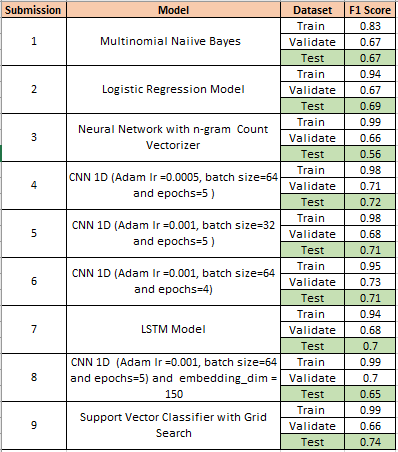

In [257]:
#List all the submissions

from IPython.display import Image
PATH = "C:/Users/Aman/Desktop/INSOFE/PHD_Exam/"
Image(filename = PATH + "All_Submissions.PNG", width=500, height=500)

The best model that outperformed the test results is "Support Vector Classifier" with Grid Search, which yeilded the F1 score of 0.74 on the test data

### Clustering the Reviews – Comparing ‘Cluster Label’ with Train data Target ‘sentiment’

In [258]:
#Load the training data

train_data2=pd.read_csv("Lionking_Cleaned_Review_TrainData.csv")

In [259]:
train_data2.head(3)

,Review_Clean,sentiment
0,i liked most that the animation made the anima...,0
1,amazing so realistic and incredible music,0
2,classic good remake loved it glover was outsta...,0


In [260]:
from sklearn.feature_extraction.text import TfidfVectorizer  


tfidf_vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1,3))  
tfidf_matrix = tfidf_vectorizer.fit_transform(train_data2['Review_Clean']) 

feature_names = tfidf_vectorizer.get_feature_names() # num phrases  

from sklearn.cluster import KMeans 

num_clusters = 2
kmeans = KMeans(n_clusters=num_clusters)  
kmeans.fit(tfidf_matrix)  
clusters = kmeans.labels_.tolist()  
train_data2['ClusterID'] = clusters  


In [261]:
train_data2.head(3)

,Review_Clean,sentiment,ClusterID
0,i liked most that the animation made the anima...,0,1
1,amazing so realistic and incredible music,0,1
2,classic good remake loved it glover was outsta...,0,1


In [262]:
print(train_data2['ClusterID'].value_counts())

1    1879
0    1121
Name: ClusterID, dtype: int64


In [263]:

#So first lets change it as { 0: positive and 1 : Negative}

train_data2['sentiment'] = train_data2['sentiment'].map({0:"positive", 1: "negative"})

In [264]:
train_data2.head(3)

,Review_Clean,sentiment,ClusterID
0,i liked most that the animation made the anima...,positive,1
1,amazing so realistic and incredible music,positive,1
2,classic good remake loved it glover was outsta...,positive,1


In [265]:
pd.crosstab(train_data2.sentiment,train_data2.ClusterID,margins=True, margins_name='Total' )

ClusterID,0,1,Total
sentiment,,,
negative,456,372,828
positive,665,1507,2172
Total,1121,1879,3000


Here we can see how the postive and negative sentiment reviews are clustered into two clusters

In [266]:
#Lets subset the sentiments based on the clusters and try to analyse it.

Cluster_0 = train_data2.query('ClusterID == 0 and (sentiment == "positive" or sentiment == "negative")')

Cluster_1 = train_data2.query('ClusterID == 1 and (sentiment == "positive" or sentiment == "negative")')

In [267]:
Cluster_0.head(3)

,Review_Clean,sentiment,ClusterID
3,nice animation cgi but completely lacking the ...,negative,0
7,i think that they should have brought back mor...,negative,0
9,it was just like the first one very good anima...,positive,0


In [268]:
Cluster_0.shape

(1121, 3)

In [269]:
Cluster_1.head(3)

,Review_Clean,sentiment,ClusterID
0,i liked most that the animation made the anima...,positive,1
1,amazing so realistic and incredible music,positive,1
2,classic good remake loved it glover was outsta...,positive,1


In [270]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

#Define a function review_wordcloud 

def review_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color="white",
        stopwords=stopwords,
        max_words=200,
        max_font_size=60, 
        scale=3,
        random_state=1 
    ).generate(str(data))
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud, )
    plt.show()

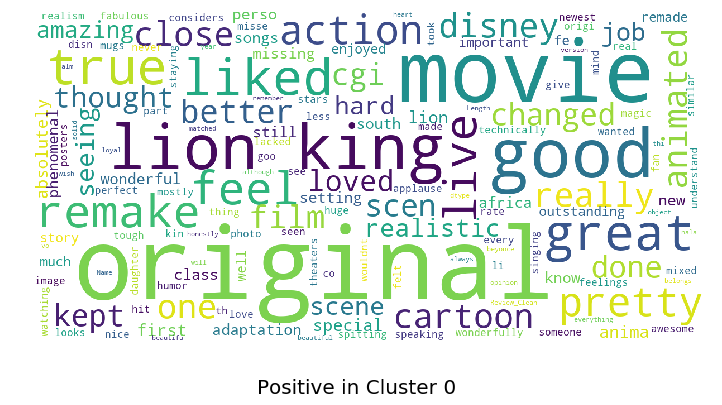

In [271]:
#Print the word cloud of positive reviews in cluster 0

review_wordcloud(Cluster_0[Cluster_0.sentiment == 'positive']["Review_Clean"],title= 'Positive in Cluster 0' )

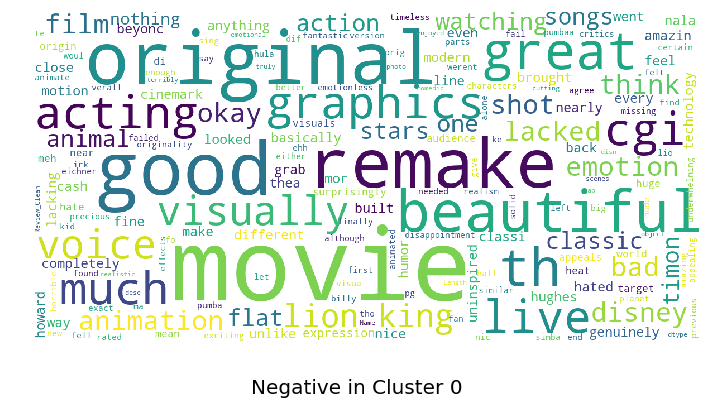

In [272]:
#Print the word cloud of negative reviews in cluster 0


review_wordcloud(Cluster_0[Cluster_0.sentiment == 'negative']["Review_Clean"],title= 'Negative in Cluster 0' )


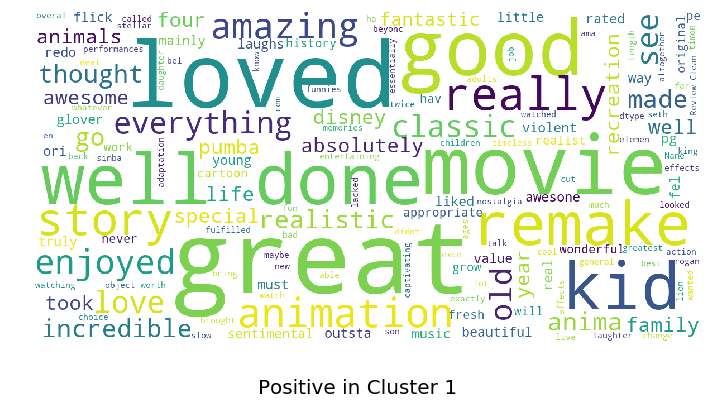

In [273]:
#Print the word cloud of Positive reviews in cluster 1


review_wordcloud(Cluster_1[Cluster_1.sentiment == 'positive']["Review_Clean"],title= 'Positive in Cluster 1' )

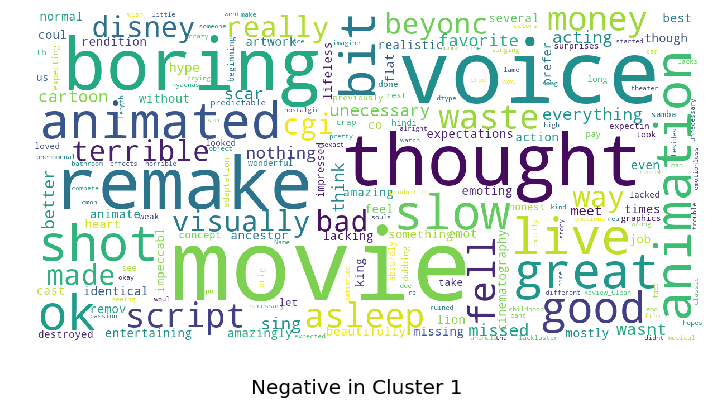

In [274]:
#Print the word cloud of negative reviews in cluster 1


review_wordcloud(Cluster_1[Cluster_1.sentiment == 'negative']["Review_Clean"],title= 'Negative in Cluster 1' )

The above four wordclouds represents two clusters. The below are my observations:
    
    - We could see frequent occured words in both the clusters are almost similar which makes sense because the words used for representing are similar.
    - There would have been clear seggregation of clusters in terms of reviews if we had more number of negative reviews in the present dataset.
    - The frequently occuring words in positive and negative reviews in this dataset has some words such has Original, Movie, Good, Great etc which are highly used in both the seniments (positive and negative)
    

### Pipeline for our Problem Statement

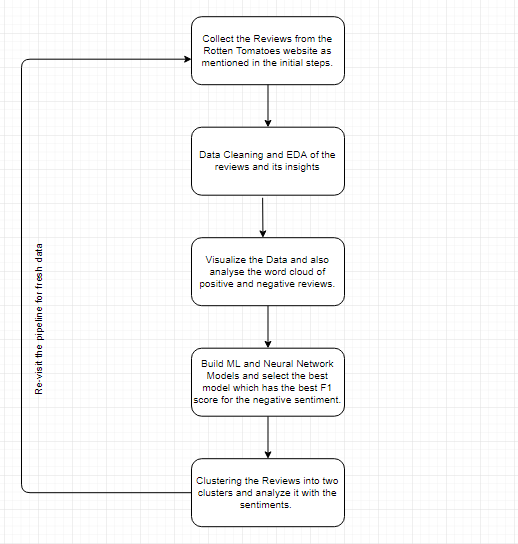

In [276]:
PATH1 = "C:/Users/Aman/Desktop/INSOFE/PHD_Exam/"
Image(filename = PATH1 + "Pipeline_For_Sentiment_Analysis.PNG", width=600, height=600)

### Conclusion

I conclude the mentioned problem with the following points:
    
    - As the movie has done well overall, the positive sentiment reviews were more than the negative sentiment reviews. It is not much of a concern for the business.
    - There have been less negative sentiment reviews in this dataset. The larger dataset with equal sentiment values will be better to analyse both sentiments in much clear way.
    
    